# Imports

In [1]:
import os
path = os.getcwd()

if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/xspec/FERMI/fermi_functions.ipynb
    %run /Home/siv30/wad005/master/GRB/src/LC_calibration.ipynb
else:
    %run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb
    %run /Users/andreas/phys/master/GRB/src/LC_calibration.ipynb
    
#read_matlab_file loaded 5 times ... not good, but need to run it in the relevant notebooks to make them work

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "
/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


FERMI functions loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

import gbm
from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

#%matplotlib inline

# Notes
    -optimal tlagg = 0.55 --> 0.69 s. Somewhere in between. 
    -ToF calculation shows that the tlagg approx is 0.66 s
    -Applying tlagg_approx to fermiTus before CC

CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# import of GBM data

In [3]:
GRB_id = "GRB210619B"
bn='bn210619999' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 319.7125, 33.8667  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?


# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix


# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function

glg_trigdat_all_bn210619999_v01.fit
645839970.604186
['n2', 'n3', 'n4', 'n7', 'n8']
n8 25.948
n4 50.977
n7 68.48
nb 71.944
b1 75.574
n3 83.856
n6 90.932
b0 104.426
n5 107.652
n9 124.02
n0 126.439
na 128.21
n1 144.304
n2 155.109


# Find temporal offset between GBM trigger time and others

In [11]:
#imports relevant modules
from gbm.time import Met
import datetime

# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(type(t0METgbm)) #checking which type it is
print(t0METgbm.datetime) #interesting that is already an datetime object?

<Met seconds = 645839970.604186>
<class 'gbm.time.Met'>
2021-06-19 23:59:25.604186+00:00


In [12]:
ToF_Fermi_ASIM = 0.0227 #light travel time in seconds
ToF_KW_ASIM = -2.6183
str_t0KW = '2021-06-19T23:59:28.157' #T0 for KW

str_t0ASIM = '2021-06-19T23:59:25.915550'

t0METASIM = t0METgbm.from_iso(str_t0ASIM)

#t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met
print("t0METASIM: ", t0METASIM)
print("ToF",ToF_Fermi_ASIM)
#Q: Why are we adding both ToF? Double check this
t0MET = t0METASIM.add(ToF_Fermi_ASIM)  # To add seconds
print("t0MET in ASIM ref frame: ", t0MET)
tshift = t0MET - t0METgbm
print("tshift: ", round(tshift,6)) #if positive: added to t0GBM to bring it into ASIM ref frame 

t0METASIM:  <Met seconds = 645839970.915550>
ToF 0.0227
t0MET in ASIM ref frame:  <Met seconds = 645839970.938250>
tshift:  0.334064


#  Extract data from selected unit(s)+

In [4]:
unit = all_dets[idx_sort_angsep][4]
#unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' 
#make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b1


In [5]:
tte = TTE.open(fn_tte)

# certain useful properties are easily accessible
print("GTI: {}".format(tte.gti))
print("Trigger time: {}".format(tte.trigtime))
print("Time Range: {}".format(tte.time_range))
print("Energy Range: {}".format(tte.energy_range))
#print('# of Energy Channels: {}'.format(tte.numchan))

GTI: [[-138.3706740140915, 476.04126596450806]]
Trigger time: 645839970.604186
Time Range: (-138.3706740140915, 476.04126596450806)
Energy Range: (104.791306, 50000.0)


# Cross Corolation
    FERMI/KW:
    -clinically cc estimates tlagg= -0.048019 s to fermi lc
    -fermi function estimates tlagg= -0.032 s
    --> 16 ms difference. latter est chooses bin after first est.
    --> seems like tlagg= -0.032 is the most accurate
    
    
    FERMI/ASIM:
    //TODO
    -Import the ASIM data and make a LC object (same procedure as with ASIM/KW)
    -Rewrite the compare function to fit with FERMI data
    

### ASIM prep

In [6]:
asimDF,T0_ASIM = complete_df(grb_id="GRB210619",remove_flag=True)

Creating df for long GRB
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
76 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
65 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
56 valleys removed
Absolute time correction subtracted from T0
49 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
subseq not found in next array ... keeping whole array
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
GRB concatenated ...
erg converted to keV
df sorted by adr

tus array OK ...


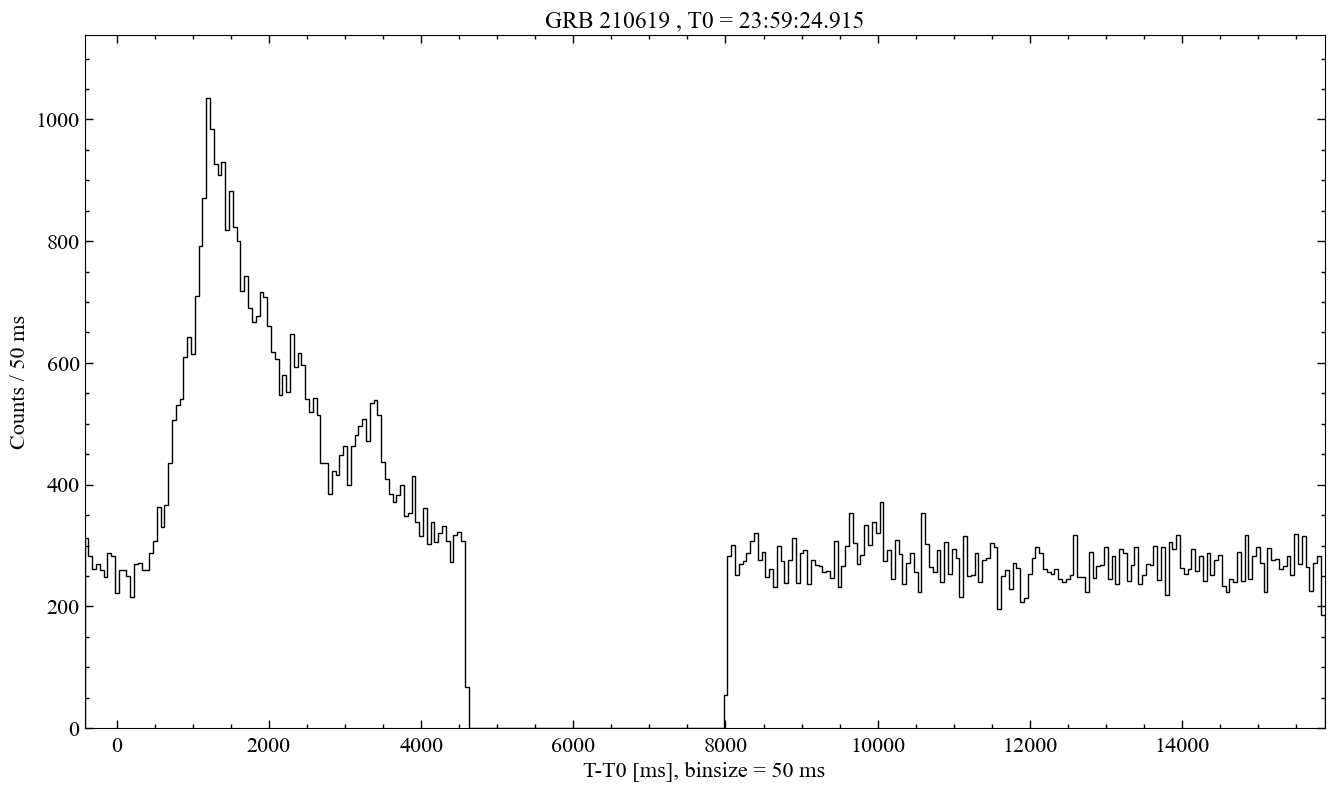

In [7]:
plot_HED(tus_arr=asimDF["tus"].to_numpy(),T0=T0_ASIM,binsize=50)

## New CC
    TODO:
    1) Create hist for asim and subtract background, DONE
    2) Apply tlaggApprox to fermiTus, DONE
    3) Cut fermTus at the appropriate start/end, DONE
    4) Create hist for fermi with the same bins as asim, DONE
    5) Subtract bkg for fermi hist, DONE
    6) plt.step for both histograms to show overlap, DONE
    7) Create LC objects from the histograms, DONE
    8) Do the CC --> result should be within -10ms to +30ms, 
    9) RESULTS: 
    binsize = 0.05, 0.016, 0.01, 0.008, 0.007 0.006 0.005, 0.004, 0.002, 0.001
    tlagg   = -0.05, -0.048, -0.06, -0.016, -0.014, -0.018, -0.06, -0.06, -0.084, -0.028

### tlaggApprox calculation

In [161]:
t0_asim = 24.915550
t0_fermi = 25.604186
ToF = 0.0227

#want to bring fermi into asim ref frame
tlaggApprox = np.round(t0_fermi-ToF-t0_asim,3)
#tlaggApprox = 0.66
print(tlaggApprox)

0.666


### finding optimal tlagg diff bins

In [167]:
#Building histogram
laggs = []
for binsize in np.arange(0.001,0.05,0.001):
    binsize=np.round(binsize,3)
    #binsize = 0.05 #50ms for LC and CC. Should be lower as the CC takes place
    asimTus = asimDF["tus"].to_numpy()/1e6
    iMax = find_nearest(asimTus,8)
    asimTus = asimTus[:iMax]
    bins = np.arange(asimTus[0],asimTus[-1]+binsize,binsize)

    asimHist = np.histogram(asimTus,bins=bins)
    asimCounts,asimEdges = asimHist[0], asimHist[1]
    #plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
    #plt.show()
    iAsimBkgEnd = find_nearest(asimEdges,0)
    asimBkg = sum(asimCounts[:iAsimBkgEnd])/len(asimCounts[:iAsimBkgEnd])

    for i,count in enumerate(asimCounts):
        if count-asimBkg <= 0:
            asimCounts[i] = 0
        else:
            asimCounts[i] -= asimBkg
    #plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
    #plt.show()

    #slicing fermiTus at the appropriate time based on asim edges
    fermiTUS = tte.data.time
    fermiTus = fermiTUS + tlaggApprox #computed above

    iFermiStart, iFermiStop = find_nearest(fermiTus,asimTus[0]), find_nearest(fermiTus,asimTus[-1])
    fermiTus = fermiTus[iFermiStart:iFermiStop]

    #Creating histogram
    fermiHist = np.histogram(fermiTus,bins=bins)
    fermiCounts,fermiEdges = fermiHist[0],fermiHist[1]
    #plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")

    #Background estimation on the same interval as asim
    iFermiBkgEnd = find_nearest(fermiEdges,0)
    fermiBkg = sum(fermiCounts[:iFermiBkgEnd])/len(fermiCounts[:iFermiBkgEnd])

    #subtracting bkg
    for i,count in enumerate(fermiCounts):
        if count-fermiBkg <= 0:
            fermiCounts[i] = 0
        else:
            fermiCounts[i] -= fermiBkg

    #plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")
    #plt.show()

    #plt.step(x=asimEdges[:-1], y=asimCounts, where="post",label="ASIM", color="black")
    #plt.step(x=fermiEdges[:-1], y=fermiCounts, where="post",label="FERMI", color="red")
    #plt.legend()
    #plt.show()

    asimLC = LC(time=asimEdges[:-1],counts=asimCounts,skip_checks=True,dt=binsize)
    fermiLC = LC(time=fermiEdges[:-1], counts=fermiCounts,skip_checks=True,dt=binsize)

    CC = CrossCorrelation(asimLC,fermiLC,mode="full")
    finalTlagg = np.round(tlaggApprox+CC.time_shift,6)
    #print(finalTlagg)
    #print(np.round(CC.time_shift,3))
    laggs.append(CC.time_shift)

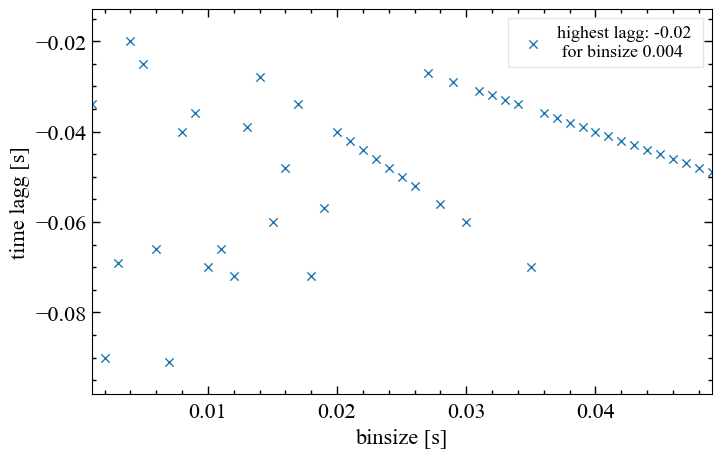

In [168]:
dt = np.arange(0.001,0.05,0.001)
iMax = find_nearest(laggs,max(laggs)) #function not working
iMin = find_nearest(laggs,min(laggs))

plt.scatter(x=dt,y=laggs,label="highest lagg: {} \n for binsize {}".format(laggs[iMax], dt[iMax]))
plt.xlabel("binsize [s]")
plt.ylabel("time lagg [s]")
plt.legend()
plt.show()

In [172]:
optTlagg = tlaggApprox + laggs[iMax] 
#should it be added or subtracted? I think it needs to be subtracted because in1=asim and therefore tlagg is estimated for fermi
print("Optimal tlagg: ", optTlagg, "for binsize: ", dt[iMax], " s")

Optimal tlagg:  0.646 for binsize:  0.004  s


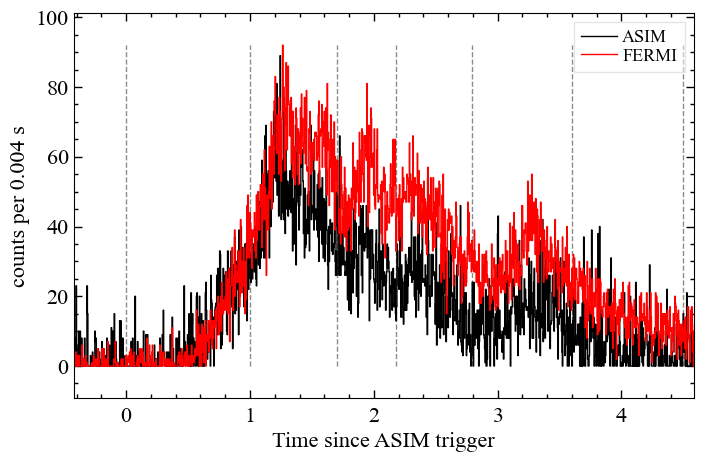

In [179]:
#checking if it needs to be added or subtracted
#making the fermiLC artificially to the right, so that tlagg has to be negative. if its positive then laggs[iMax] must be subtracted
binsize = 0.004 #50ms for LC and CC. Should be lower as the CC takes place
asimTus = asimDF["tus"].to_numpy()/1e6
iMax = find_nearest(asimTus,8)
asimTus = asimTus[:iMax]
bins = np.arange(asimTus[0],asimTus[-1]+binsize,binsize)

asimHist = np.histogram(asimTus,bins=bins)
asimCounts,asimEdges = asimHist[0], asimHist[1]
#plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
#plt.show()
iAsimBkgEnd = find_nearest(asimEdges,0)
asimBkg = sum(asimCounts[:iAsimBkgEnd])/len(asimCounts[:iAsimBkgEnd])

for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg
#plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
#plt.show()

#slicing fermiTus at the appropriate time based on asim edges
fermiTUS = tte.data.time
fermiTus = fermiTUS+tlaggApprox

iFermiStart, iFermiStop = find_nearest(fermiTus,asimTus[0]), find_nearest(fermiTus,asimTus[-1])
fermiTus = fermiTus[iFermiStart:iFermiStop]

#Creating histogram
fermiHist = np.histogram(fermiTus,bins=bins)
fermiCounts,fermiEdges = fermiHist[0],fermiHist[1]
#plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")

#Background estimation on the same interval as asim
iFermiBkgEnd = find_nearest(fermiEdges,0)
fermiBkg = sum(fermiCounts[:iFermiBkgEnd])/len(fermiCounts[:iFermiBkgEnd])

#subtracting bkg
for i,count in enumerate(fermiCounts):
    if count-fermiBkg <= 0:
        fermiCounts[i] = 0
    else:
        fermiCounts[i] -= fermiBkg

#plt.step(x=fermiEdges[:-1],y=fermiCounts,where="post")
#plt.show()

plt.step(x=asimEdges[:-1], y=asimCounts, where="post",label="ASIM", color="black")
plt.step(x=fermiEdges[:-1], y=fermiCounts, where="post",label="FERMI", color="red")
plt.legend()

#intervals
T0,T1,T2,T3,T4,T5,T6 = 0,1,1.7,2.18,2.79,3.60,4.5
txtUpperLimit = max(fermiCounts)
plt.vlines(x=[T0,T1,T2,T3,T4,T5,T6],ymin=[0]*7,ymax=[txtUpperLimit]*7,color="grey",alpha=0.9,linestyle="--")
plt.ylabel("counts per {} s".format(binsize))
plt.xlabel("Time since ASIM trigger")
plt.show()

### final CC

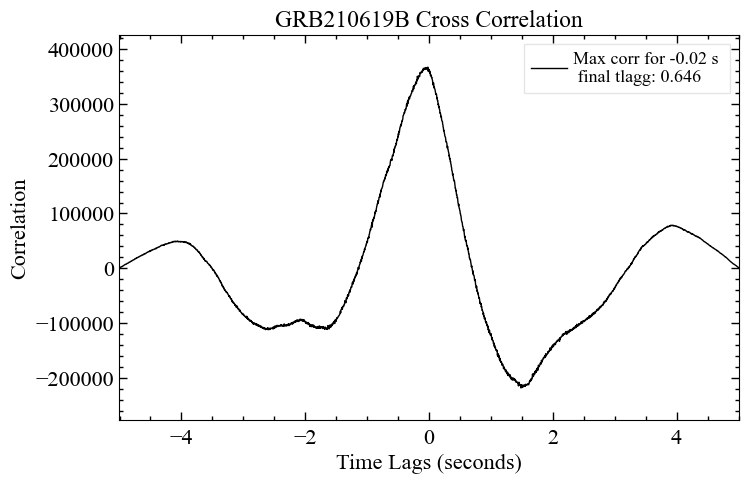

0.646


In [178]:
asimLC = LC(time=asimEdges[:-1],counts=asimCounts,skip_checks=True,dt=binsize)
fermiLC = LC(time=fermiEdges[:-1], counts=fermiCounts,skip_checks=True,dt=binsize)
finalTlagg = np.round(tlaggApprox + CC.time_shift,3)
CC = CrossCorrelation(asimLC,fermiLC,mode="full")
plt.plot(CC.time_lags,CC.corr,label="Max corr for {} s \n final tlagg: {} ".format(CC.time_shift,finalTlagg), c="black")
plt.title("GRB210619B Cross Correlation")
plt.xlabel('Time Lags (seconds)')
plt.ylabel('Correlation')
plt.legend(loc="upper right")
#plt.savefig("/Users/andreas/phys/master/GRB/xspec/GRB210619B/CrossCorrolation/CC_asim_fermi.pdf")
plt.show()
print(finalTlagg)

### Superposition of LC's

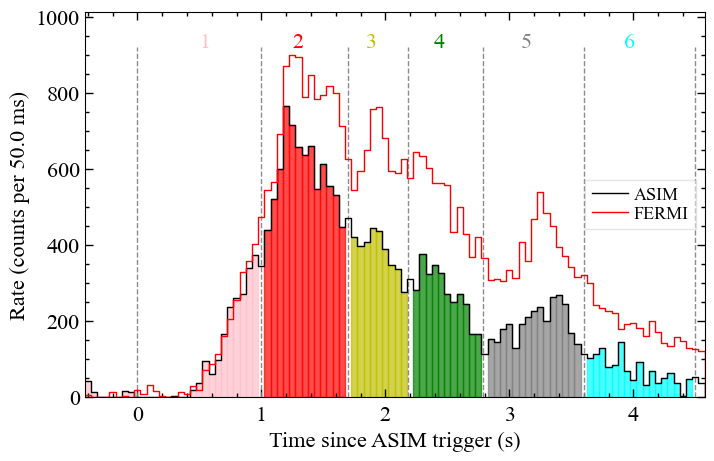

In [212]:
#slicing fermiTus at the appropriate time based on asim edges
binsize = 0.05 #50ms for LC and CC. Should be lower as the CC takes place
asimTus = asimDF["tus"].to_numpy()/1e6
iMax = find_nearest(asimTus,8)
asimTus = asimTus[:iMax]
bins = np.arange(asimTus[0],asimTus[-1]+binsize,binsize)

asimHist = np.histogram(asimTus,bins=bins)
asimCounts,asimEdges = asimHist[0], asimHist[1]

iAsimBkgEnd = find_nearest(asimEdges,0)
asimBkg = sum(asimCounts[:iAsimBkgEnd])/len(asimCounts[:iAsimBkgEnd])
for i,count in enumerate(asimCounts):
    
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg
        
fermiTUS = tte.data.time

fermiTus = fermiTUS + finalTlagg

iFermiStart, iFermiStop = find_nearest(fermiTus,asimTus[0]), find_nearest(fermiTus,asimTus[-1])
fermiTus = fermiTus[iFermiStart:iFermiStop]

#Creating histogram
fermiHist = np.histogram(fermiTus,bins=bins)
fermiCounts,fermiEdges = fermiHist[0],fermiHist[1]

#Background estimation on the same interval as asim
iFermiBkgEnd = find_nearest(fermiEdges,0)
fermiBkg = sum(fermiCounts[:iFermiBkgEnd])/len(fermiCounts[:iFermiBkgEnd])

#subtracting bkg
for i,count in enumerate(fermiCounts):
    if count-fermiBkg <= 0:
        fermiCounts[i] = 0
    else:
        fermiCounts[i] -= fermiBkg


fig,ax = plt.subplots(1, 1)
ax.step(x=asimEdges[:-1],y=asimCounts,where="post",color="black",label="ASIM")
ax.step(x=fermiEdges[:-1],y=fermiCounts,where="post",color="red",label="FERMI")

ax.set_xlabel("Time since ASIM trigger (s)")
ax.set_ylabel("Rate (counts per {} ms)".format(binsize*1e3))

#Filling in time interval regions
T0,T1,T2,T3,T4,T5,T6 = 0,1,1.7,2.18,2.79,3.60,4.5

for n, l, r in zip(asimCounts, asimEdges, asimEdges[1:-1]):
    if r < T1:
        ax.fill_between([l, r], 0, n, alpha=0.7,color="pink")
    elif np.logical_and(l>=T1,r<=T2):
        ax.fill_between([l, r], 0, n, alpha=0.7,color="red")
    elif np.logical_and(l>=T2,r<=T3):
        ax.fill_between([l, r], 0, n, alpha=0.7,color="y")
    elif np.logical_and(l>=T3,r<=T4):
        ax.fill_between([l, r], 0, n, alpha=0.7,color="g")
    elif np.logical_and(l>=T4,r<=T5):
        ax.fill_between([l, r], 0, n, alpha=0.7,color="grey")
    elif np.logical_and(l>=T5,r<=T6):
        ax.fill_between([l, r], 0, n, alpha=0.7,color="cyan")

txtUpperLimit = max(fermiCounts)+20

ax.vlines(x=[T0,T1,T2,T3,T4,T5,T6],ymin=[0]*7,ymax=[txtUpperLimit]*7,color="grey",alpha=0.9,linestyle="--")

ax.text((T1+T0)/2,txtUpperLimit,"1",fontsize=16,c="pink")
ax.text((T2+T1-0.2)/2,txtUpperLimit,"2",fontsize=16,c="red")
ax.text((T3+T2-0.2)/2,txtUpperLimit,"3",fontsize=16,c="y")
ax.text((T4+T3-0.2)/2,txtUpperLimit,"4",fontsize=16,c="g")
ax.text((T5+T4-0.2)/2,txtUpperLimit,"5",fontsize=16,c="grey")
ax.text((T6+T5-0.25)/2,txtUpperLimit,"6",fontsize=16,c="cyan")
ax.set_ylim(ymin=0)
ax.legend(loc="center right")
#plt.savefig("/Users/andreas/phys/master/GRB/xspec/GRB210619B/CrossCorrolation/OverlappingLC_tlagg{}ms.pdf".format(int(finalTlagg*1e3)))
plt.show()

### open a old TTE file and change the trigtime manually.
#See docs at https://fermi.gsfc.nasa.gov/ssc/data/analysis/gbm/gbm_data_tools/gdt-docs/api/api-data.html#tte 

bint = 0.05 #binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
#phaii = tte.to_phaii(bin_by_time, bint) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (150,4e4) #usually advised lower range. Standard passband

lc_data = phaii.to_lightcurve(energy_range=erange)

lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (0,5)

# New shifted TTE object

tte shifted by 0.67
new TTE object created


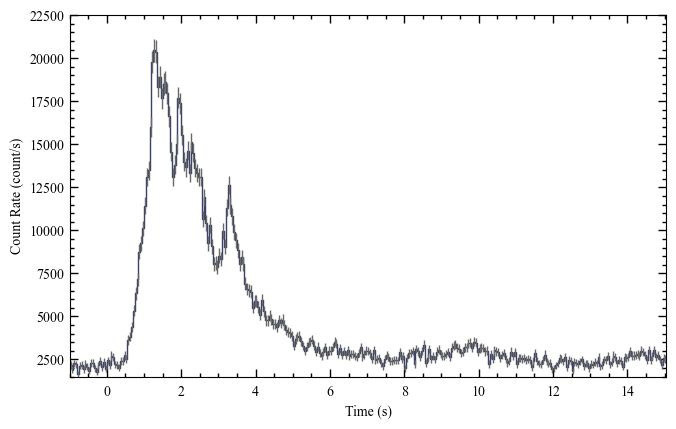

In [270]:
erange = (150,4e4)
binsize=0.05
newTTE = createNewTTE(oldTTEObj=tte,tlagg=0.67,
                      binsize=0.05,
                      unit=unit,
                      obj=GRB_id,
                      grb_ra=grb_ra,
                      grb_dec=grb_dec)

phaii = newTTE.to_phaii(bin_by_time,binsize)
lcdata = phaii.to_lightcurve(time_range=(-1,15),energy_range=erange)
lc = Lightcurve(data=lcdata)

### Background estimation

In [271]:
# Fit background
bkgd_times = [(-130,-5)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

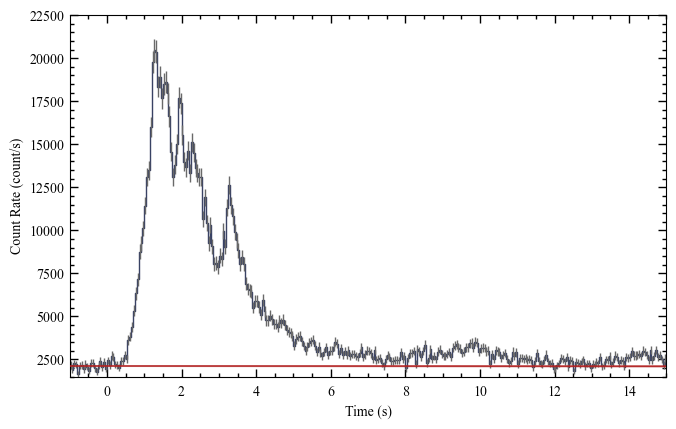

In [272]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lcdata, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-1, 15)
lcplot.xlim = view_range

In [483]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([ 7.51843331,  1.87198748,  1.60557138,  1.35294372,  1.05725194,
        0.88605928,  0.90283674,  0.85933284,  0.83896248,  0.85781752,
        0.85868189,  0.8489299 ,  0.89343617,  0.85260676,  0.86645165,
        0.8524516 ,  0.86414189,  0.79916901,  0.83763692,  0.86941129,
        0.84048495,  0.84720492,  0.83826427,  0.85659874,  1.01029763,
        0.99007743,  1.13230369,  1.24347373,  1.3926317 ,  1.35743524,
        1.35327178,  1.61033666,  1.62255452,  1.42025962,  1.49887786,
        1.4894822 ,  1.78003459,  1.51431715,  1.45905172,  1.42768352,
        1.35528399,  1.44746656,  1.60217296,  1.73237421,  1.82298111,
        1.86051115,  1.87909337,  1.92037692,  2.15899559,  2.02563789,
        2.31194032,  2.61091875,  2.42026854,  2.417842  ,  2.31472769,
        2.52414996,  2.60443576,  2.4983046 ,  2.63956806,  2.60961606,
        2.70065738,  2.86639979,  2.8641238 ,  2.60873894,  3.10878386,
        2.96327312,  2.73217672,  3.12926749,  2.33944931,  2.71

### FIX THIS BACKGROUND RESIDUALS TEST

In [370]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.logical_and(lcdata.centroids>bkgd_times[0][0],lcdata.centroids<bkgd_times[0][1]) #removed: | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1]))
isel_bkg = np.logical_and(lc_bkgd.time_centroids>bkgd_times[0][0],lc_bkgd.time_centroids<bkgd_times[0][1]) #removed | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) 

In [365]:
# what is this: lcdata.centroids()


array([False, False, False, ..., False, False, False])

In [371]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


### Extracting GBM data

(3.6, 4.5)


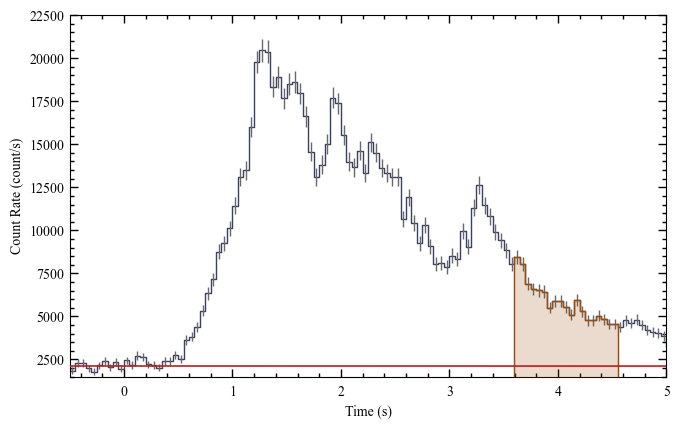

In [291]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (T5,T6)
print(src_time)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange) #erange = (150keV-40MeV)

lcplot = Lightcurve(data=lcdata, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = (-0.5,5) #view_range

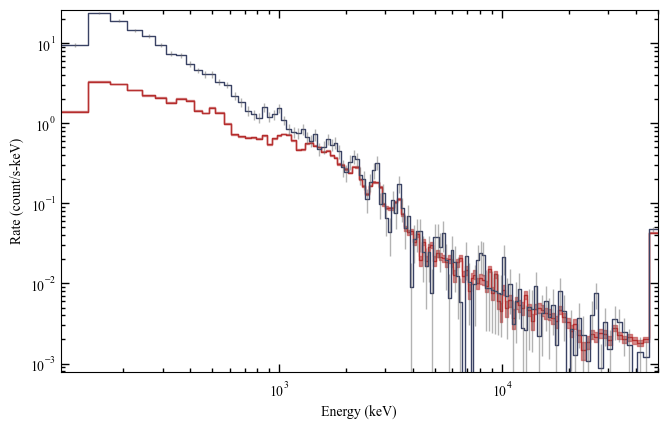

In [292]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = newTTE.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

# Extract fits files

In [293]:
# Extract the corresponding PHA from source and bkg files
pha = newTTE.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey GRB210619B_b1.rsp GRB210619B_b1.pha+2 RESPFILE


In [26]:
# Time intervals for spectra
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
